# Current Procedure



In [ ]:
pip install brisque

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import imageio
import scipy, scipy.misc, scipy.signal
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import sys,os
import warnings
warnings.filterwarnings("ignore", message="spsolve requires A be CSC or CSR matrix format")
import PIL
from PIL import Image
from brisque import BRISQUE


In [ ]:

def computeTextureWeights(fin, sigma, sharpness):
    dt0_v = np.vstack((np.diff(fin, n=1, axis=0), fin[0,:]-fin[-1,:]))
    dt0_h = np.vstack((np.diff(fin, n=1, axis=1).conj().T, fin[:,0].conj().T-fin[:,-1].conj().T)).conj().T

    gauker_h = scipy.signal.convolve2d(dt0_h, np.ones((1,sigma)), mode='same')
    gauker_v = scipy.signal.convolve2d(dt0_v, np.ones((sigma,1)), mode='same')

    W_h = 1/(np.abs(gauker_h)*np.abs(dt0_h)+sharpness/2)
    W_v = 1/(np.abs(gauker_v)*np.abs(dt0_v)+sharpness/2)

    return  W_h, W_v

In [ ]:
def solveLinearEquation(IN, wx, wy, lamda):
    [r, c] = IN.shape
    k = r * c
    dx =  -lamda * wx.flatten('F')
    dy =  -lamda * wy.flatten('F')
    tempx = np.roll(wx, 1, axis=1)
    tempy = np.roll(wy, 1, axis=0)
    dxa = -lamda *tempx.flatten('F')
    dya = -lamda *tempy.flatten('F')
    tmp = wx[:,-1]
    tempx = np.concatenate((tmp[:,None], np.zeros((r,c-1))), axis=1)
    tmp = wy[-1,:]
    tempy = np.concatenate((tmp[None,:], np.zeros((r-1,c))), axis=0)
    dxd1 = -lamda * tempx.flatten('F')
    dyd1 = -lamda * tempy.flatten('F')
    
    wx[:,-1] = 0
    wy[-1,:] = 0
    dxd2 = -lamda * wx.flatten('F')
    dyd2 = -lamda * wy.flatten('F')
    
    Ax = scipy.sparse.spdiags(np.concatenate((dxd1[:,None], dxd2[:,None]), axis=1).T, np.array([-k+r,-r]), k, k)
    Ay = scipy.sparse.spdiags(np.concatenate((dyd1[None,:], dyd2[None,:]), axis=0), np.array([-r+1,-1]), k, k)
    D = 1 - ( dx + dy + dxa + dya)
    A = ((Ax+Ay) + (Ax+Ay).conj().T + scipy.sparse.spdiags(D, 0, k, k)).T
    
    tin = IN[:,:]
    tout = scipy.sparse.linalg.spsolve(A, tin.flatten('F'))
    # Fortran-style ordering
    OUT = np.reshape(tout, (r, c), order='F')
    
    return OUT
    

In [ ]:
def tsmooth(img, lamda=0.01, sigma=3.0, sharpness=0.001):
    I = cv2.normalize(img.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    x = np.copy(I)
    wx, wy = computeTextureWeights(x, sigma, sharpness)
    S = solveLinearEquation(I, wx, wy, lamda)
    return S


In [ ]:
def rgb2gm(I):
    if (I.shape[2] == 3):
        I = cv2.normalize(I.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
        # geometric mean is a non-linear method
        #  It gives more weight to the smaller pixel values and less weight to the larger pixel values
        I = np.abs((I[:,:,0]*I[:,:,1]*I[:,:,2]))**(1/3)
        # CHANGE 1

    return I

In [ ]:
def applyK(I, k, a=-0.3293, b=1.1258):
   
    # power law transformation with gamma correction
    f = lambda x: np.exp((1-x**a)*b)
    # beta = exp((1-k^a)*b)
    beta = f(k)
    # esult is then multiplied by k raised to the power
    #  of a to compensate for the effect of the power law transformation.
    gamma = k**a
    J = (I**gamma)*beta
    return J

In [ ]:
def entropy(X):
    tmp = X * 255
    tmp[tmp > 255] = 255
    tmp[tmp<0] = 0
    tmp = tmp.astype(np.uint8)
    #  The histogram of the image is calculated and the probability of each pixel value is calculated
    _, counts = np.unique(tmp, return_counts=True)
    pk = np.asarray(counts)
    # entropy of the image is calculated as the negative 
    # sum of the product of each probability and its logarithm, using base 2.
    pk = 1.0*pk / np.sum(pk, axis=0)
    S = -np.sum(pk * np.log2(pk), axis=0)
    return S

In [ ]:

def maxEntropyEnhance(I, isBad, a=-0.3293, b=1.1258):
    # Esatimate k
    tmp = cv2.resize(I, (50,50), interpolation=cv2.INTER_AREA)
    tmp[tmp<0] = 0
    tmp = tmp.real
    Y = rgb2gm(tmp)
    
    isBad = isBad * 1
  
    # MAKE A TUPLE OF (50,50)
    size = (50,50)
    
    # image_pil=Image.fromarray(isBad)
    image_pil = Image.fromarray(np.uint8(isBad))
    if size:
        bic=Image.BICUBIC
        image_pil=image_pil.resize(size, bic)
        isBad=np.array(image_pil)
   
    isBad[isBad < 0.5] = 0
    isBad[isBad >= 0.5] = 1


    # # IndexError: boolean index did not match indexed array along dimension 0; dimension is 50 but corresponding boolean dimension is 301
    # resize isBad to 50,50

    Y = Y[isBad==1]
    
    if Y.size == 0:
       J = I
       return J
    
    f = lambda k: -entropy(applyK(Y, k))
    opt_k = scipy.optimize.fminbound(f, 1, 7)
    # opt_k=0.5
    # Apply k
    # J = applyK(I, opt_k) - 0.01
    J = applyK(I, opt_k, a, b) - 0.01
    return J
    

In [ ]:

def fusion(img, mu=0.5, a=-0.3293, b=1.1258):
    lamda = 0.5
    sigma = 5
    # input image
    I = cv2.normalize(img.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)

    # Weight matrix estimation
    t_b = np.max(I, axis=2)
    # resized_image=scipy.misc.imresize(t_b, 0.5, interp='bicubic', mode='F')
    img2 = np.array(Image.fromarray(t_b).resize(
    (int(0.5 * t_b.shape[0]), int(t_b.shape[1] * 0.5)),
    resample=PIL.Image.BICUBIC)
)

    t_our = cv2.resize(tsmooth(img2, lamda, sigma), (t_b.shape[1], t_b.shape[0]), interpolation=cv2.INTER_AREA)
   
  
    # Apply camera model with k(exposure ratio)
    isBad = t_our < 0.5
    J = maxEntropyEnhance(I, isBad)

    # W: Weight Matrix
    t = np.zeros((t_our.shape[0], t_our.shape[1], I.shape[2]))
    for i in range(I.shape[2]):
        t[:,:,i] = t_our
    W = t**mu

    I2 = I*W
    J2 = J*(1-W)

    result = I2 + J2
    result = result * 255
    result[result > 255] = 255
    result[result<0] = 0
    return result.astype(np.uint8)

PSNR: 14.88 dB
SSIM: 0.33
Brisque Score: 35.36094659549585


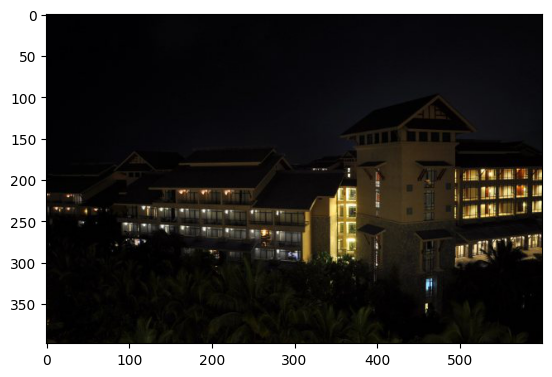

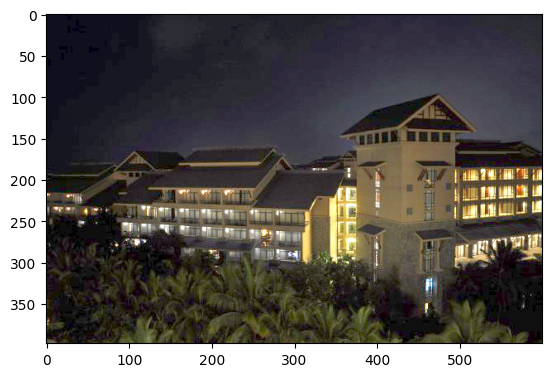

In [ ]:
img_name = '/content/sample_data/testImage1.jpg'
img = imageio.v2.imread(img_name)
result = fusion(img)
psnr_value = psnr(img, result, data_range=255)

# calculate SSIM
ssim_value = ssim(img, result, channel_axis=-1, data_range=255)


# print results
print("PSNR: {:.2f} dB".format(psnr_value))
print("SSIM: {:.2f}".format(ssim_value))

imageio.v3.imwrite('/content/sample_data/EnhancedImage.png', result)
obj = BRISQUE(url=False)
result_img = cv2.imread('/content/sample_data/EnhancedImage.png', cv2.IMREAD_COLOR).astype(np.uint8)
print("Brisque Score:",obj.score(result_img))
plt.imshow(img)
plt.show()
plt.imshow(result)
plt.show()